In [ ]:
!unzip /content/nerve_segmentation_FINAL.zip 

Archive:  /content/nerve_segmentation_FINAL.zip
   creating: content/nerve_segmentation/
  inflating: content/nerve_segmentation/unet.py  
  inflating: content/nerve_segmentation/preprocessing.py  
  inflating: content/nerve_segmentation/train.py  
   creating: content/nerve_segmentation/.ipynb_checkpoints/
  inflating: content/nerve_segmentation/.ipynb_checkpoints/main_script-checkpoint.ipynb  
  inflating: content/nerve_segmentation/.ipynb_checkpoints/main_test-checkpoint.ipynb  
  inflating: content/nerve_segmentation/metrics.py  
  inflating: content/nerve_segmentation/functional.py  
  inflating: content/nerve_segmentation/losses.py  
  inflating: content/nerve_segmentation/test.py  
  inflating: content/nerve_segmentation/main_script.ipynb  
   creating: content/nerve_segmentation/__pycache__/
  inflating: content/nerve_segmentation/__pycache__/metrics.cpython-38.pyc  
  inflating: content/nerve_segmentation/__pycache__/preprocessing.cpython-38.pyc  
  inflating: content/nerve_se

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from nerve_segmentation import functional
from nerve_segmentation import losses
from nerve_segmentation import metrics 
from nerve_segmentation import preprocessing

from nerve_segmentation.unet import UNet
import os
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import cv2

In [ ]:
# Jaccard loss, MSE
# Adam Optimizer
# Learning rate schedule
# Checkpoint
# Fixed Size = 512x512

MODEL_NAME = "Segmentation UNET"
# path to zipped & working directories
path_train = '/content/drive/MyDrive/Nerve Segementation/train'

Images shape: (20, 512, 512, 3)


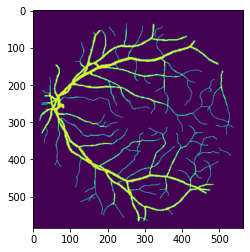

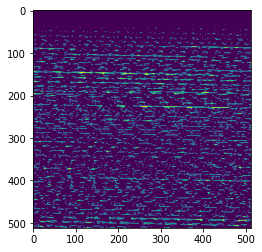

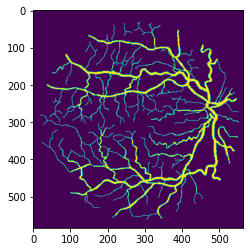

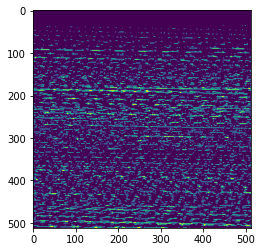

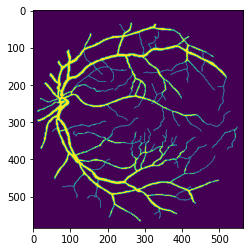

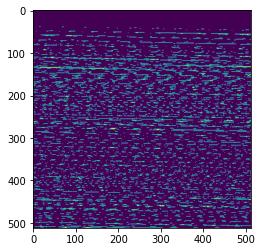

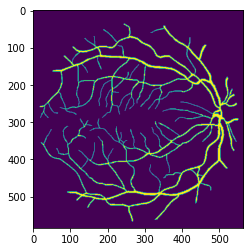

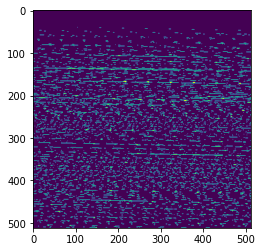

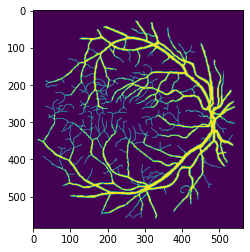

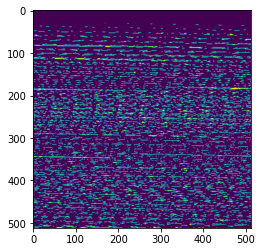

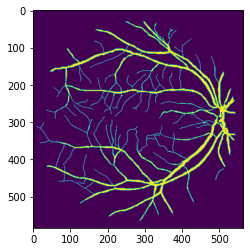

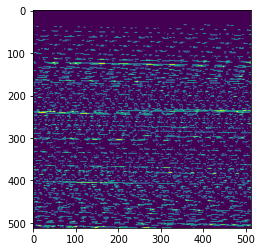

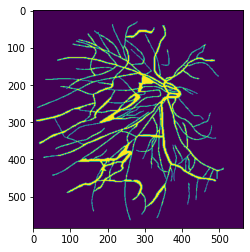

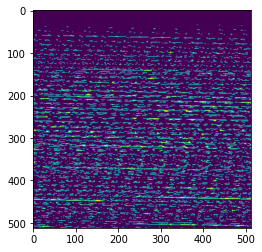

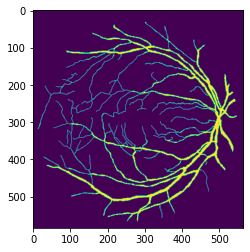

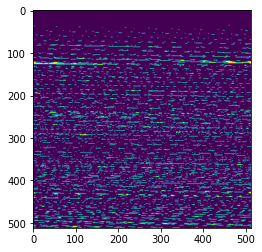

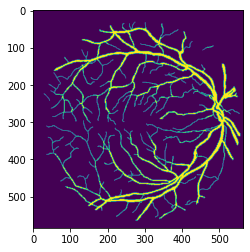

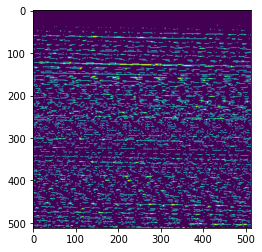

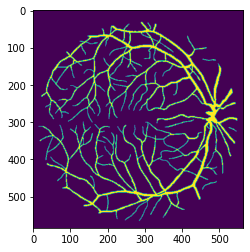

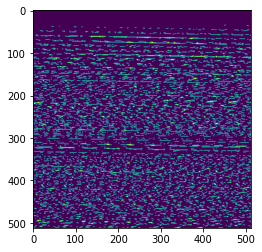

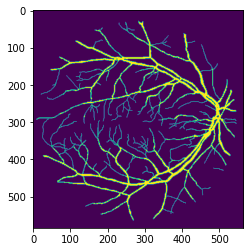

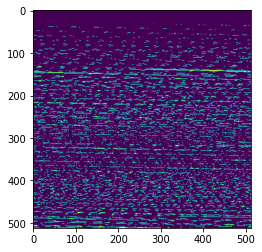

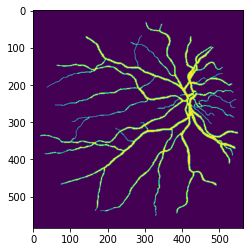

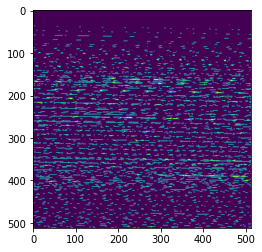

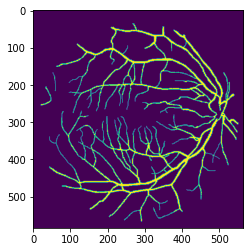

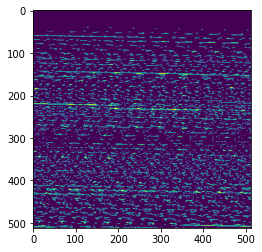

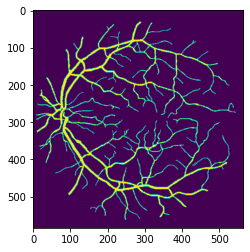

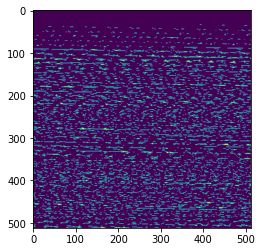

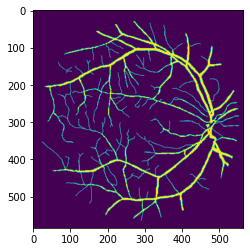

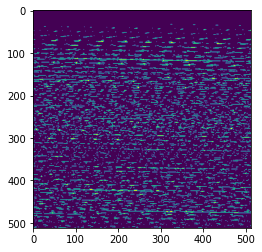

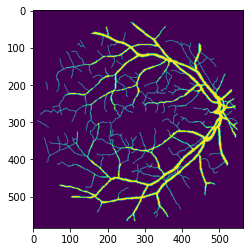

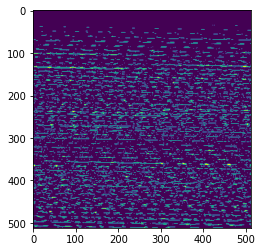

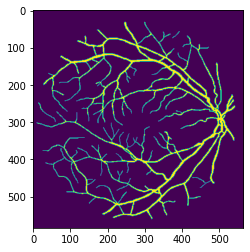

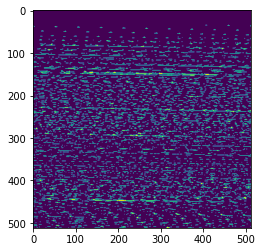

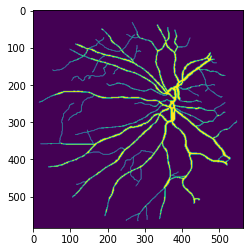

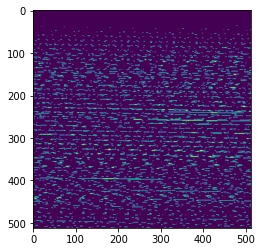

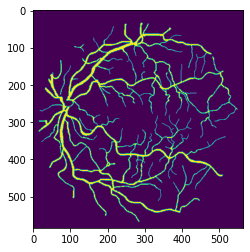

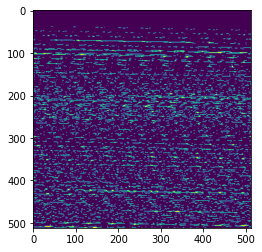

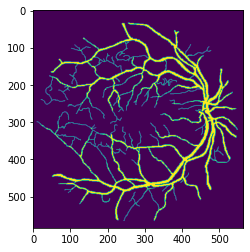

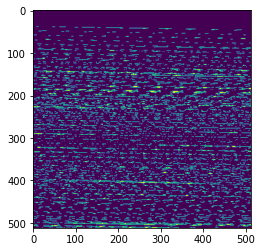

Labels shape: (20, 512, 512)


In [ ]:
import os
import cv2
import imageio
import numpy as np

# Train

# Define the path to the dataset
path_train = '/content/drive/MyDrive/Nerve Segementation/train'

# Load the images into a list
images_train = []

# Loop through each image in the images folder
for filename in os.listdir(os.path.join(path_train, "images")):
    # Read the TIF file using OpenCV
    image = cv2.imread(os.path.join(path_train, "images", filename))
    
    # Convert the image to a numpy array
    image = np.array(image)

    # resize
    image = np.resize(image, (512, 512, 3))
    plt.imshow(image)
    plt.show()
    # Append the image to the list
    images_train.append(image)

# Convert the list of images to a single numpy array
images_train = np.array(images_train)

# Print the shape of the array to confirm it has been loaded correctly
print("Images shape:", images_train.shape)

# Load the labels into a list
labels_train = []

# Loop through each label in the labels folder
for filename in os.listdir(os.path.join(path_train, "labels")):
    # Read the gif file using imageio
    label = imageio.mimread(os.path.join(path_train, "labels", filename))
    
    label = np.array(label)
    label = np.reshape(label, (584, 565, 1))

    # resize
    label = np.resize(label, (512, 512, 1))

    # Convert the list of frames to a single numpy array
    label = np.stack(label)
    
    # Append the label to the list
    labels_train.append(label)

# Convert the list of labels to a single numpy array
labels_train = np.array(labels_train)

# Print the shape of the array to confirm it has been loaded correctly
print("Labels shape:", labels_train.shape)

In [ ]:
# Test

# Define the path to the dataset
path_test = '/content/drive/MyDrive/Nerve Segementation/test'

# Load the images into a list
images_test = []

# Loop through each image in the images folder
for filename in os.listdir(os.path.join(path_train, "images")):
    # Read the TIF file using OpenCV
    image = cv2.imread(os.path.join(path_train, "images", filename))
    
    # Convert the image to a numpy array
    image = np.array(image)
    
    # Append the image to the list
    images_test.append(image)

# Convert the list of images to a single numpy array
images_test = np.array(images_test)

# Print the shape of the array to confirm it has been loaded correctly
print("Images shape:", images_test.shape)

Images shape: (20, 584, 565, 3)


In [ ]:
# Print Number of Images found
print(f'Training Images: {len(images_train)}')
print(f'Training Image Labels: {len(labels_train)}')
# print(f'Validation Images: {len(validation_img)}')
# print(f'Validation Image Labels: {len(validation_cleaned_img)}')
images = [i for i in images_train if i not in labels_train]
print(images)

Training Images: 20
Training Image Labels: 20
[]


In [ ]:
images_train[0].shape

(512, 512, 3)

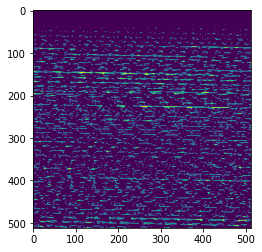

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(labels_train[0].reshape(512, 512))

In [ ]:
# del train
# del train_cleaned
# del validate
# del validate_cleaned

In [ ]:
model = UNet((512, 512, 3), 16, 'transpose2d')
checkpoint = tf.keras.callbacks.ModelCheckpoint(f"/content/drive/MyDrive/Experiments/ckpt/{MODEL_NAME}/best_model", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1,
                              patience=5, 
                              min_lr=10e-12, 
                              verbose=1)

In [ ]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [ ]:
model.compile(optimizer=Adam(learning_rate = 10e-4), 
              loss=jaccard_distance, 
              metrics=[metrics.IOUScore(threshold=0.5), metrics.FScore(threshold=0.5)],
              )

In [ ]:
images_train = images_train/255.
labels_train = labels_train/1.

In [ ]:
history = model.fit(images_train, labels_train, 
                    epochs=50, 
                    callbacks=[reduce_lr, checkpoint])

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: -7.5688 - iou_score: 6.0293 - f1-score: 1.7145

1/1 [==============================] - 26s 26s/step - loss: -7.5688 - iou_score: 6.0293 - f1-score: 1.7145 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: -24.0119 - iou_score: 20.4810 - f1-score: 1.9057

1/1 [==============================] - 1s 1s/step - loss: -24.0119 - iou_score: 20.4810 - f1-score: 1.9057 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: -357.5517 - iou_score: 23.2457 - f1-score: 1.9161

1/1 [==============================] - 1s 1s/step - loss: -357.5517 - iou_score: 23.2457 - f1-score: 1.9161 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: -2245.8008 - iou_score: 23.8682 - f1-score: 1.9181

1/1 [==============================] - 1s 997ms/step - loss: -2245.8008 - iou_score: 23.8682 - f1-score: 1.9181 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: -2325.9028 - iou_score: 24.2673 - f1-score: 1.9194

1/1 [==============================] - 1s 978ms/step - loss: -2325.9028 - iou_score: 24.2673 - f1-score: 1.9194 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: -2327.5566 - iou_score: 24.2850 - f1-score: 1.9195

1/1 [==============================] - 1s 962ms/step - loss: -2327.5566 - iou_score: 24.2850 - f1-score: 1.9195 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - ETA: 0s - loss: -2327.7798 - iou_score: 24.2867 - f1-score: 1.9195

1/1 [==============================] - 1s 955ms/step - loss: -2327.7798 - iou_score: 24.2867 - f1-score: 1.9195 - lr: 0.0010
Epoch 8/50
1/1 [==============================] - ETA: 0s - loss: -2328.1199 - iou_score: 24.2901 - f1-score: 1.9195

1/1 [==============================] - 1s 963ms/step - loss: -2328.1199 - iou_score: 24.2901 - f1-score: 1.9195 - lr: 0.0010
Epoch 9/50
1/1 [==============================] - ETA: 0s - loss: -2327.9917 - iou_score: 24.2888 - f1-score: 1.9195

1/1 [==============================] - 1s 959ms/step - loss: -2327.9917 - iou_score: 24.2888 - f1-score: 1.9195 - lr: 0.0010
Epoch 10/50
1/1 [==============================] - ETA: 0s - loss: -2328.1060 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 956ms/step - loss: -2328.1060 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 11/50
1/1 [==============================] - ETA: 0s - loss: -2328.1060 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 955ms/step - loss: -2328.1060 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 12/50
1/1 [==============================] - ETA: 0s - loss: -2328.1042 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 970ms/step - loss: -2328.1042 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 13/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 965ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 14/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 971ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 15/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 961ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 16/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 979ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 17/50
1/1 [==============================] - ETA: 0s - loss: -2328.1030 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 986ms/step - loss: -2328.1030 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 18/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 964ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 19/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 954ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 20/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 963ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 21/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 980ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 22/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 955ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 23/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 958ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 24/50
1/1 [==============================] - ETA: 0s - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 954ms/step - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 25/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 954ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 26/50
1/1 [==============================] - ETA: 0s - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 972ms/step - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 27/50
1/1 [==============================] - ETA: 0s - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 960ms/step - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 28/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 960ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 29/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 987ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 30/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 998ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 31/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 999ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 32/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 969ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 33/50
1/1 [==============================] - ETA: 0s - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 969ms/step - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 34/50
1/1 [==============================] - ETA: 0s - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 970ms/step - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 35/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 968ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 36/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 969ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 37/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 970ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 38/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 977ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 39/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 978ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 40/50
1/1 [==============================] - ETA: 0s - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 977ms/step - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 41/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 991ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 42/50
1/1 [==============================] - ETA: 0s - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 1s/step - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 43/50
1/1 [==============================] - ETA: 0s - loss: -2328.1028 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 1s/step - loss: -2328.1028 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 44/50
1/1 [==============================] - ETA: 0s - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 1s/step - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 45/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 990ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 46/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 990ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 47/50
1/1 [==============================] - ETA: 0s - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 986ms/step - loss: -2328.1023 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 48/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 997ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 49/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 993ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010
Epoch 50/50
1/1 [==============================] - ETA: 0s - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195

1/1 [==============================] - 1s 989ms/step - loss: -2328.1021 - iou_score: 24.2899 - f1-score: 1.9195 - lr: 0.0010


In [ ]:
print(images_train.shape)

(20, 512, 512, 3)


In [ ]:
model.save('/content/drive/MyDrive/Experiments/segment_model')

In [ ]:
##########################################
# Test Script
##########################################

In [ ]:
if __name__ == "__main__":
    model = UNet((512, 512, 1), 64, 'transpose2d')
    model.load_weights('ckpt_path')

    path = 'Data/Segmentation'
    test_img = sorted(os.listdir(path + '/Test/Input'))
    test_cleaned_img = sorted(os.listdir(path + '/Test/Output'))

    test = []
    test_cleaned = []

    path3 = 'Data/Segmentation/Test'

    # Testing
    for f in sorted(os.listdir(path3 + '/Input')):
        test.append(process_image(path3 + '/Input/' + f))

    for f in sorted(os.listdir(path3 + '/Output')):
        test_cleaned.append(process_image(path3 + '/Output/' + f))

    X_test = np.asarray(test)
    Y_test = np.asarray(test_cleaned)

    del test
    del test_cleaned

    predictions = model.predict(X_test)

    iou_50 = MeanIOU(list(predictions), list(Y_test), threshold = 0.5)
    dice_50 = MeanDiceCoeff(list(predictions), list(Y_test), threshold = 0.5)

    iou_75 = MeanIOU(list(predictions), list(Y_test), threshold = 0.75)
    dice_75 = MeanDiceCoeff(list(predictions), list(Y_test), threshold = 0.75)

    iou_90 = MeanIOU(list(predictions), list(Y_test), threshold = 0.9)
    dice_90 = MeanDiceCoeff(list(predictions), list(Y_test), threshold = 0.9)

NotFoundError: ignored

In [ ]:
!zip -r nerve_segmentation.zip /content/nerve_segmentation

In [ ]:
tf.__version__